In [1]:
# library imports
import devtools
import sklearn
import pmdarima
from nowcast_lstm.LSTM import LSTM
import numpy as np
import pandas as pd
import torch

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# Data set up

In [8]:
# data read
metadata = pd.read_csv("../data/russian_meta_data.csv")

# usual method
# data = pd.read_csv("../data/russian_data_tf.csv", parse_dates=["date"])

# distillation from LSTM
# step 0 (usual destillation from LSTM)
# data = pd.read_csv("../data/russian_LSTM_predictions+rest_train.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted)
# data = pd.read_csv("../data/russian_LSTM_predictions_step2.csv", parse_dates=["date"])

# distillation from GB
# step 0 (usual destillation from GB)
# data = pd.read_csv("../data/russian_GB_predictions_distillation.csv", parse_dates=["date"])
# step 1 (mean of real and forecasted) (from GB)
# data = pd.read_csv("../data/russian_GB_predictions_step1.csv", parse_dates=["date"])
# step 2 (mean of real and forecasted for otliers - where big errors)
data = pd.read_csv("../data/russian_GB_predictions_step2.csv", parse_dates=["date"])


target_variable = "gdp"
# target_variable = "cpi"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
if target_variable == "gdp":
    lags = list(range(-2,3))
else:
    lags = list(range(-5, 1))

# train and test dates
train_start_date = "2004-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2023-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [9]:
data.tail()

,date,ibved,cpi,oil_price,rate,exchange_rate,m2,us_cpi,PMI,unemployment,gdp
237,2023-10-01,-0.003476,0.007528,-0.050174,0.056536,0.018606,0.007443,0.006135,-0.020110,-0.042565,NaN
238,2023-11-01,-0.002770,0.008603,-0.054758,0.138056,-0.071001,0.016074,0.000000,-0.022388,-0.000486,NaN
239,2023-12-01,0.009221,0.004878,-0.016119,0.031674,0.014419,0.013206,0.000000,0.062977,0.017713,0.015419
240,2024-01-01,-0.006672,0.005015,-0.004557,0.033918,-0.000310,0.014697,0.006098,-0.010772,-0.038277,NaN
241,2024-02-01,NaN,0.004907,0.022936,0.000000,0.011464,0.017927,0.000000,-0.052632,NaN,NaN


# Training the model

In [10]:
model = LSTM(
    data = train,
    target_variable = target_variable,
    n_timesteps = 6,
    fill_na_func = np.nanmean,
    fill_ragged_edges_func = np.nanmean,
    n_models = 10,
    train_episodes = 100,
    batch_size = 50,
    decay = 0.98,
    n_hidden = 10,
    n_layers = 1,
    dropout = 0.0,
    criterion = torch.nn.MSELoss(),
    optimizer = torch.optim.Adam,
    optimizer_parameters = {"lr":1e-3, "weight_decay":0.0}
)
model.train(quiet=True)

# Testing the model on artificial data vintages

In [11]:
# dates in the test set (ORIGINAL!!!!!!! - testing on test data)
if target_variable == "gdp":
    dates = (
            # for GDP
            pd.date_range(test_start_date, test_end_date, freq="3MS")
            .strftime("%Y-%m-%d")
            .tolist()
        )
elif target_variable == "cpi":
    dates = (
            # for GDP
            pd.date_range(test_start_date, test_end_date, freq="1MS")
            .strftime("%Y-%m-%d")
            .tolist()
        )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [11]:
# dates in the test set (MY!!!!!!!!!! - testing on train data)
# !NB what is pd.date_range(...)[2:], why starts from 3?
if target_variable == "gdp":
    dates = (
            # for GDP
            pd.date_range(train_start_date, train_end_date, freq="3MS")[4:]
            .strftime("%Y-%m-%d")
            .tolist()
        )
elif target_variable == "cpi":
    dates = (
            # for Inflation
            pd.date_range(train_start_date, train_end_date, freq="1MS")[8:]
            .strftime("%Y-%m-%d")
            .tolist()
        )    

# actual values
actuals = list(train.loc[train.date.isin(dates), target_variable].values)
# actuals

In [12]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        
        # the predict function will give a whole dataframe, only interested in the prediction for this date
        pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
        # choose lag = 2 as it has the most info and will be more accurate
        if lag == 2:
            print(date, pred)
        pred_dict[lag].append(pred)

2018-03-01 0.009171683341264725
2018-06-01 0.007540494203567505
2018-09-01 0.0064013199880719185
2018-12-01 0.007021777331829071
2019-03-01 0.00496017187833786
2019-06-01 0.007422646973282099
2019-09-01 0.006105456501245499
2019-12-01 0.007224240340292454
2020-03-01 0.008958824910223484
2020-06-01 -0.0006859598797746003
2020-09-01 0.008403550833463669
2020-12-01 0.007267894688993692
2021-03-01 0.009211362339556217
2021-06-01 0.007128273136913776
2021-09-01 0.006156373769044876
2021-12-01 0.007045727223157883
2022-03-01 0.006608162075281143
2022-06-01 -0.005289152264595032
2022-09-01 0.013241201639175415
2022-12-01 0.008730863220989704
2023-03-01 0.007835501804947853
2023-06-01 0.006998063530772924
2023-09-01 0.0063363900408148766
2023-12-01 0.0038159252144396305


# Assess and visualize model performance

In [13]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
        "MAE":np.mean(np.abs(np.array(actuals) - np.array(pred_dict[lag])))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE,MAE
0,-2,0.0249,0.0126
1,-1,0.0248,0.0126
2,0,0.0248,0.0124
3,1,0.0249,0.0125
4,2,0.0249,0.0125


''

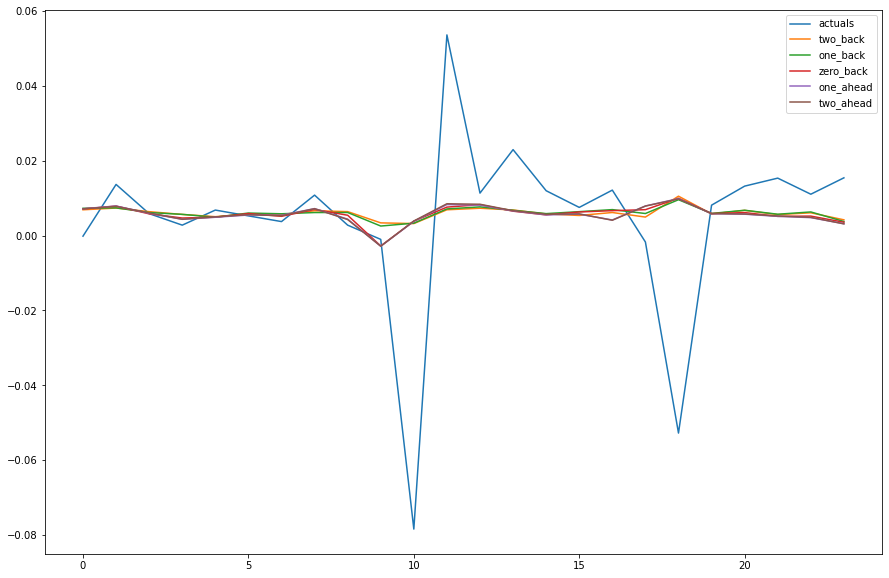

In [10]:
# plot of predictions vs actuals
if target_variable == "gdp":
    plot_dict = {
        "actuals":actuals, 
        "two_back":pred_dict[-2], 
        "one_back":pred_dict[-1], 
        "zero_back":pred_dict[0],
        "one_ahead":pred_dict[1],
        "two_ahead":pred_dict[2]}
else:
    plot_dict = {
        "actuals":actuals, 
        "two_back":pred_dict[-2], 
        "one_back":pred_dict[-1], 
        "zero_back":pred_dict[0]}
    
pd.DataFrame(plot_dict).plot()
;

# Hyperparameter tuning
To hyperparameter tune, you would wrap everything from "Training the model" to "Assess and visualize performance" in a loop and save the performance metrics to a csv. In pseudo code:


```
for hyperparam1 in [option1, option2]:
    for hyperparam2 in [option1, option2]:
    ...
        model = your_model(hyperparam1 = hyperparam1 ...)
        ...
        results = results.append(tmp_results)
results.to_csv("results.csv", index=False)
```

In v0.2.0 of the _nowcast\_lstm_ library, you can now perform hyperparameter tuning from within the library with the `hyperparameter_tuning` function, no need to set up your own loops. See the [repository's](https://github.com/dhopp1/nowcast_lstm) example file for more information. Variable selection can also be performed from within the library via the `variable_selection` function.

## Below is a list of recommended hyperparameter values to use for grid search with the LSTM if results are not very good with default parameters
- *n_timesteps* (for a quarterly target variable): **[3, 6, 12]**
- *n_timesteps* (for a yearly target variable): **[12, 24]**
- *fill_ragged_edges_func*: **[np.nanmean, "ARMA"]** (warning: ARMA can take a very long time to estimate, the mean is usually capable of getting good predictions and is much faster)
- *n\_models*: **[10]** (this can usually be kept to 10 as a good balance between consistent predictions and estimation time)
- *train_episodes*: **[50, 100, 200]**
- *batch_size*: **[50, 100, 200]**
- *decay*: **[0.98]** (this is fine to keep at the default value of 0.98)
- *n_hidden*: **[10, 20, 40]**
- *n_layers*: **[1, 2, 4]**
- *dropout*: **[0.0]** (this is fine to keep at the default value of 0.0, using `weight_decay` instead for additional regularization if necessary)
- *criterion*: **[torch.nn.L1Loss(), torch.nn.MSELoss()]**
- *optimizer*: **[torch.optim.Adam]** (this is usually fine to keep at the default of Adam)
- *lr*: **[1e-2]** (this is fine to keep at the default value because of the `decay` parameter)
- *weight_decay*: **[0.0]** (this is usually fine to keep at 0.0, neural networks already perform a sort of regularization)

**Note**: `lr` and `weight_decay` should be passed to the `optimizer_parameters` function as a dictionary, e.g. `optimizer_parameters = {"lr": 1e-2, "weight_decay": 0.0}`

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [10]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# obtain prediction for the new period
model.predict(new_data).loc[lambda x: x.date == "2011-03-01","predictions"].values[0]

0.00692784134298563